In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import h5py
import pandas

import sys
sys.path.append(os.path.abspath('..'))
import utils

from scipy.stats import zscore

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fdir = '/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/'
glob.glob(fdir + '*xls*')

['/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/Sub03_Run_Breakdown.xls',
 '/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/Subject 3 Runs with specific object info.xlsx']

In [3]:
# Load two excel files as data frames in pandas
df1 = pandas.read_excel(os.path.join(fdir, 'Sub03_Run_Breakdown.xls'))
df2 = pandas.read_excel(os.path.join(fdir, 'Subject 3 Runs with specific object info.xlsx'))

In [4]:
# Extract useful variables
# For the first xls file
run = df1['Run'].values
onset = df1['BV Start'].values
offset = df1['BV Stop'].values
cat = df1['Run6'].values
# Separate indices for the second xls file
objects = df2['object'].values
# A little cleanup to get rid of extra quotes
print(objects[:3]) # before
objects = np.array([o.strip("'''") for o in objects])
print(objects[:3]) # after (no extra quotes)
conditions = df2['condition'].values
# Similar cleanup
conditions = np.array([c.strip("'") for c in conditions])
object_run = df2['run'].values

["'''Head phones'''" "'''Ice cream scoop'''" "'''Bandages'''"]
['Head phones' 'Ice cream scoop' 'Bandages']


(array([ 3., 31., 32., 31., 36., 20., 12.,  1.,  1.,  1.]),
 array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22.]),
 <a list of 10 Patch objects>)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


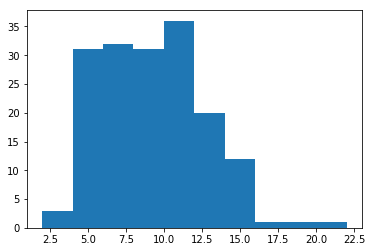

In [5]:
# Define simple model of word features
word2feature = dict((w, len(w)) for w in objects)
plt.hist(word2feature.values(), bins=10)

In [6]:
# Start with a list
X_list = []
n_runs = 7
n_TRs_per_run = 127
n_conditions = 3 # could be: n_features. If so don't forget to change it below.
for this_run in range(1, n_runs+1):
    Xtmp = np.zeros((n_TRs_per_run, n_conditions))
    ri_xls1 = run==this_run
    ri_xls2 = object_run==this_run
    # Word onsets were when it was NOT fixation and NOT 
    word_on = ~((cat[ri_xls1]=='Fixation') | (cat[ri_xls1]=='Response'))
    all_onsets_thisrun = onset[ri_xls1]
    word_onsets_thisrun = all_onsets_thisrun[word_on] - 1
    
    conds_thisrun = conditions[ri_xls2]
    objects_thisrun = objects[ri_xls2]
    for itrial in range(0,24):
        on = word_onsets_thisrun[itrial]
        o = objects_thisrun[itrial]
        cond = conds_thisrun[itrial]
        #cond_idx = cond2number[cond]
        # OR: define object2feature (see below), and call this:
        wl = word2feature[o]
        if wl < 7:
            feature_idx = 0
        elif wl > 10:
            feature_idx = 2
        else:
            # 7 <= wl <= 10
            feature_idx = 1
        # ... and then use feature_idx as the index for Xtmp in the next line 
        # instead of cond_idx
        Xtmp[on, feature_idx] = 1
    # For each run, add the X variable we have created to a list:
    X_list.append(Xtmp)
# ... and concatenate everything here:
X = np.vstack(X_list)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


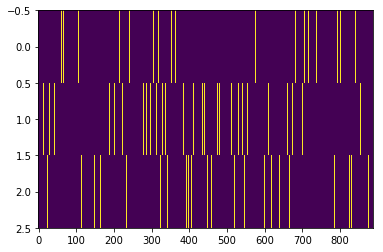

In [7]:
plt.imshow(X.T, aspect='auto')

# fMRI data

In [8]:
fdir = '/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/'
all_files = sorted(glob.glob(fdir + '*mat'))
unsmoothed_files = all_files[::2]
smoothed_files = all_files[1::2]

In [9]:
# Create a list for data
data = []
# Load each file into list
for file in smoothed_files:
    print("Loading %s"%file)
    with h5py.File(file) as hf:
        d = hf['data'].value
    #print('Original size: ', d.shape)
    # Transpose data so time is first axis
    d = d.T
    # Map the 4 values returned by d.shape to separate variables
    t, z, y, x = d.shape
    #print('Transposed size: ', d.shape)
    # Reshape data to be time x (all voxels)
    d = np.reshape(d, (127, -1)) # the -1 here means string everything all out into one vector
    #print('Reshaped size: ', d.shape)
    # standardize by run, because that makes many things easier
    data.append(zscore(d, axis=0))

Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN01_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN02_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2248: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN03_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN04_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN05_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN06_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN07_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat


In [10]:
Y = np.nan_to_num(np.vstack(data))
print(Y.shape)

(889, 106720)


In [12]:
tt, hh = utils.fmri.hrf(tr=3)
Xh = utils.fmri.hrf_convolve(X, hh)

In [13]:
n_est = -200
B = utils.ols(Xh[:n_est], Y[:n_est])

In [14]:
B.shape

(3, 106720)

In [16]:
y_hat = Xh[n_est:].dot(B)
r = utils.column_corr(y_hat, Y[n_est:])

/home/mark/Code/UNR_PSY_763/utils/__init__.py:11: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda x: (x-np.nanmean(x, axis=0))/np.nanstd(x, axis=0, ddof=dof)
/home/mark/Code/UNR_PSY_763/utils/__init__.py:17: RuntimeWarning: invalid value encountered in true_divide
  r = rTmp/n


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


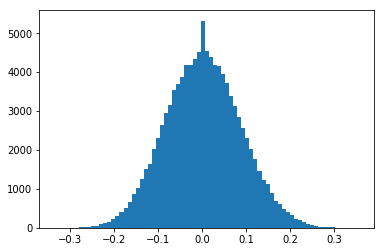

In [17]:
plt.hist(np.nan_to_num(r), bins=75);

In [18]:
brain = utils.fmri.get_brain(unsmoothed_files[0])

/home/mark/Code/UNR_PSY_763/utils/fmri.py:141: RuntimeWarning: invalid value encountered in greater
  alpha = (np.abs(data) > threshold).astype(np.float)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


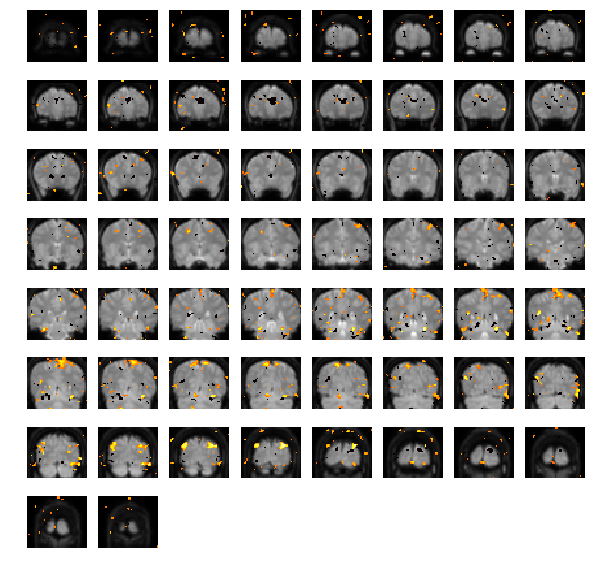

In [20]:
utils.fmri.overlay_brain(r, brain, threshold=0.18, vmin=0, vmax=0.35, cmap='hot')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


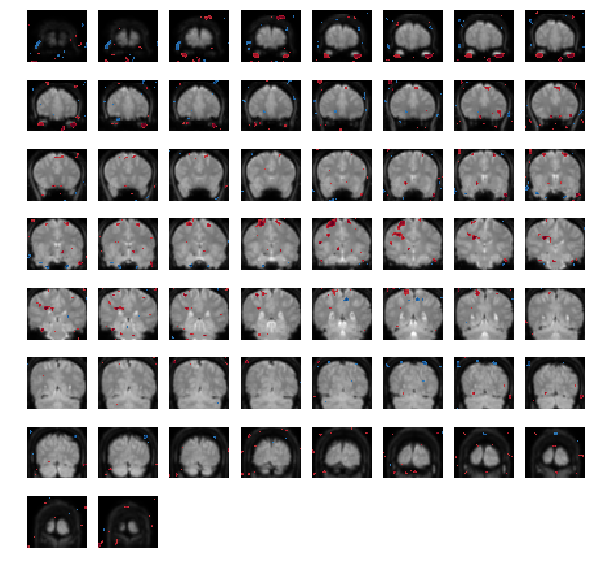

In [21]:
# Where do longer words elicit more activity than shorter words? 
Bdif = np.nan_to_num(B[2] - B[0])
#plt.hist(Bdif, bins=51);
utils.fmri.overlay_brain(Bdif, brain, threshold=0.7, vmin=-1, vmax=1, cmap='RdBu_r')